In [38]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px  # for interactive visuals (optional)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [39]:
# Set a fresh plotting style different from previous examples
plt.style.use('ggplot')
sns.set_theme(style="darkgrid", palette="magma")
plt.rcParams['figure.figsize'] = (10, 6)

In [41]:
# 1. Data Loading and Exploration
# Assume heart.csv is in the working directory.
heart_df = pd.read_csv("heart.csv")
print("Dataset shape:", heart_df.shape)
print("\nDataset preview:")
heart_df.head()

Dataset shape: (1025, 14)

Dataset preview:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [42]:
print("\nData types and missing values:")
heart_df.info()


Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [43]:
# Display target distribution (target: 0 = No disease, 1 = Disease)
print("\nTarget distribution:")
print(heart_df['target'].value_counts())


Target distribution:
target
1    526
0    499
Name: count, dtype: int64


In [46]:
# List of features assumed to be present (example columns from Kaggle Heart Disease dataset)
# 'age', 'sex', 'cp' (chest pain type), 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'

# For this example, convert 'cp', 'restecg', 'slope', 'thal' to categorical features via one-hot encoding.
categorical_features = ['cp', 'restecg', 'slope', 'thal']
heart_df_encoded = pd.get_dummies(heart_df, columns=categorical_features, drop_first=True)

# Check the columns after encoding
print("\nColumns after encoding:")
print(heart_df_encoded.columns)


Columns after encoding:
Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak',
       'ca', 'target', 'cp_1', 'cp_2', 'cp_3', 'restecg_1', 'restecg_2',
       'slope_1', 'slope_2', 'thal_1', 'thal_2', 'thal_3'],
      dtype='object')


In [47]:
# Separate features and target
X = heart_df_encoded.drop(columns=['target'])
y = heart_df_encoded['target']

# Scale numerical features (all features in X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# %% [code]
# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42, stratify=y
)
print("\nTraining set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])



Training set size: 820
Test set size: 205


In [48]:
# 4. Build the MLP Model using Keras
def build_mlp_model(input_dim):
    model = Sequential([
        Dense(64, activation="relu", input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid")  # Sigmoid for binary classification
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [49]:
mlp_model = build_mlp_model(X_train.shape[1])
mlp_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 64)                  │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 192 (768.00 B)

In [50]:
# 5. Model Training with Early Stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
history = mlp_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5894 - loss: 0.6985 - val_accuracy: 0.7073 - val_loss: 0.5847
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7412 - loss: 0.5225 - val_accuracy: 0.7744 - val_loss: 0.5202
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7880 - loss: 0.4578 - val_accuracy: 0.7927 - val_loss: 0.4732
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8367 - loss: 0.4002 - val_accuracy: 0.7988 - val_loss: 0.4370
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8037 - loss: 0.3981 - val_accuracy: 0.8354 - val_loss: 0.4083
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8610 - loss: 0.3512 - val_accuracy: 0.8537 - val_loss: 0.3813
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8435 - loss: 0.3435 - val_accuracy: 0.8598 - val_loss: 0.3647
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8210 - loss: 0.3827 - val_accuracy: 0.8720 - 

In [51]:
# 6. Model Evaluation
y_pred_prob = mlp_model.predict(X_test).flatten()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       100
           1       0.97      1.00      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.98      0.99       205
weighted avg       0.99      0.99      0.99       205



In [52]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[ 97   3]
 [  0 105]]


In [55]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc:.3f}")


ROC AUC Score: 1.000


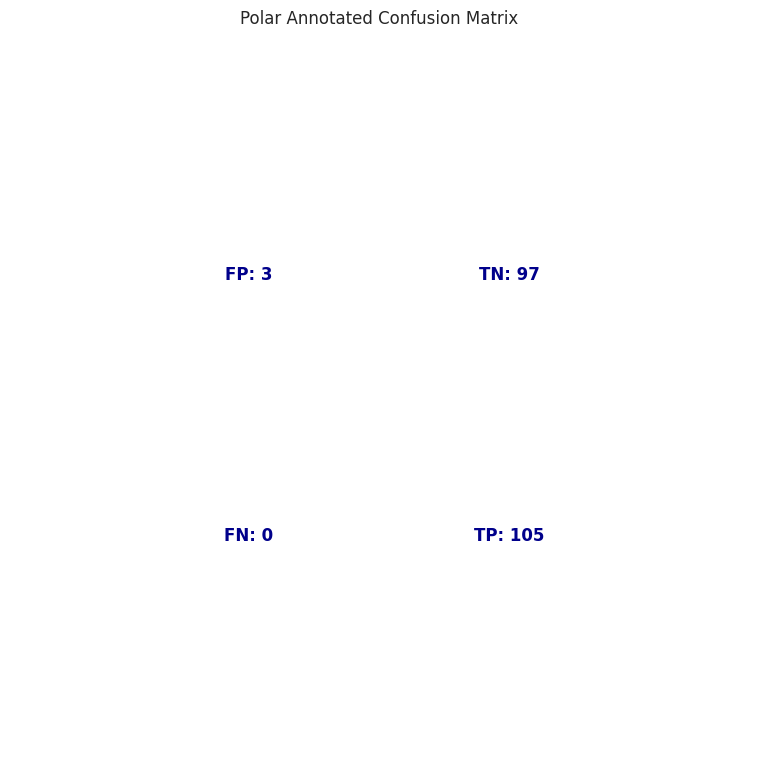

In [56]:
# 7.1 Confusion Matrix using a Custom Circular Heatmap (Polar Coordinates)
plt.figure(figsize=(8,8))
theta = np.linspace(0.0, 2 * np.pi, 100)
r = np.linspace(0, 1, 100)
T, R = np.meshgrid(theta, r)
# Instead of plotting the full heatmap, we annotate a polar plot with confusion matrix values.
# Custom approach: Plot text in a circular layout.
plt.subplot(111, projection='polar')
plt.axis('off')
# Annotate the four cells in polar coordinates
labels = [["TN: {}".format(cm[0,0]), "FP: {}".format(cm[0,1])],
          ["FN: {}".format(cm[1,0]), "TP: {}".format(cm[1,1])]]
angles = [np.pi/4, 3*np.pi/4, 5*np.pi/4, 7*np.pi/4]
radii = [0.5, 0.5, 0.5, 0.5]
for i in range(4):
    plt.text(angles[i], radii[i], labels[i//2][i%2],
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=12, fontweight='bold', color='darkblue')
plt.title("Polar Annotated Confusion Matrix", va='bottom')
plt.tight_layout()
plt.show()

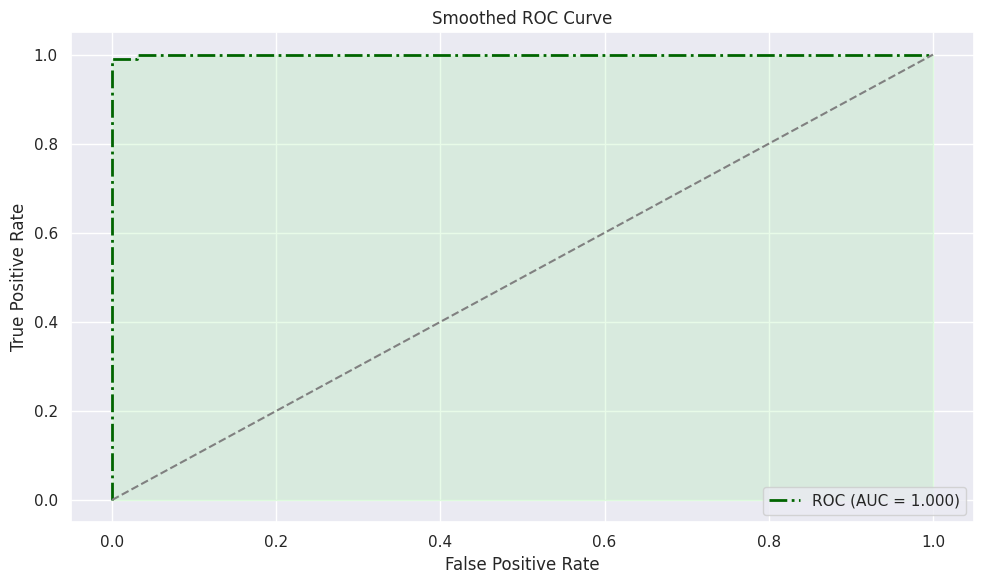

In [57]:
# 7.2 ROC Curve with Smoothing Effect
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, linestyle='-.', color='darkgreen', linewidth=2, label=f"ROC (AUC = {roc_auc:.3f})")
plt.fill_between(fpr, tpr, alpha=0.2, color='lightgreen')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Smoothed ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (21,) and (20,)

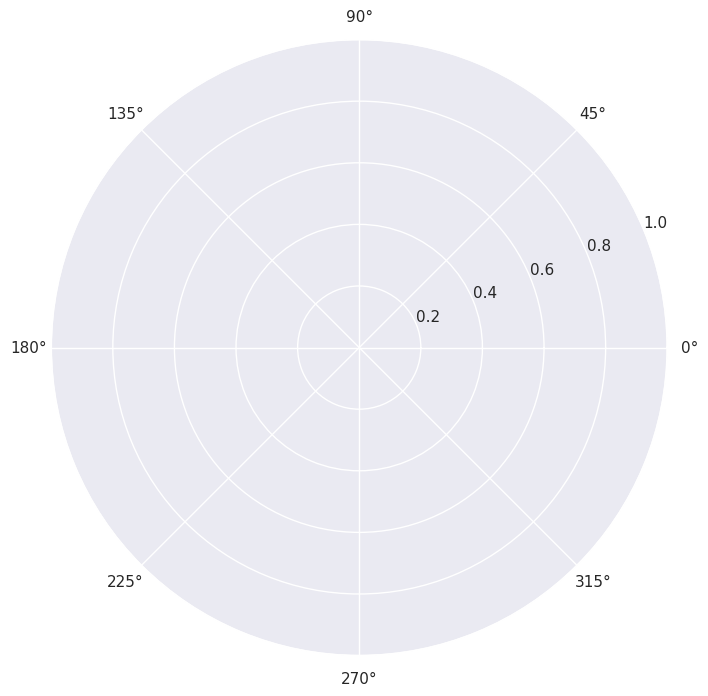

In [59]:
# 7.3 Radar Chart for Feature Importance
# For a new visualization, we compute feature importance from the trained MLP using permutation importance
# (Note: For demonstration, we use a simple approximation using model weights from the first Dense layer)
import math

weights = mlp_model.layers[0].get_weights()[0]  # shape: (input_dim, 64)
# Compute the average absolute weight for each input feature
avg_abs_weights = np.mean(np.abs(weights), axis=1)
features = X.columns.tolist()

# Normalize for radar chart
norm_weights = avg_abs_weights / np.max(avg_abs_weights)

# Radar chart requires repeating the first value at the end
labels = features + [features[0]]
stats = norm_weights.tolist() + [norm_weights[0]]

# Radar chart using matplotlib polar plot
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, stats, 'o-', linewidth=2, color='indigo')
ax.fill(angles, stats, alpha=0.25, color='indigo')
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Radar Chart of Estimated Feature Importance", y=1.1, fontweight='bold')
ax.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-60-5c2e816ef37b>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x='Actual', y='Predicted_Prob', data=prob_df, palette="Set2", size=8)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 35.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 41.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-pa

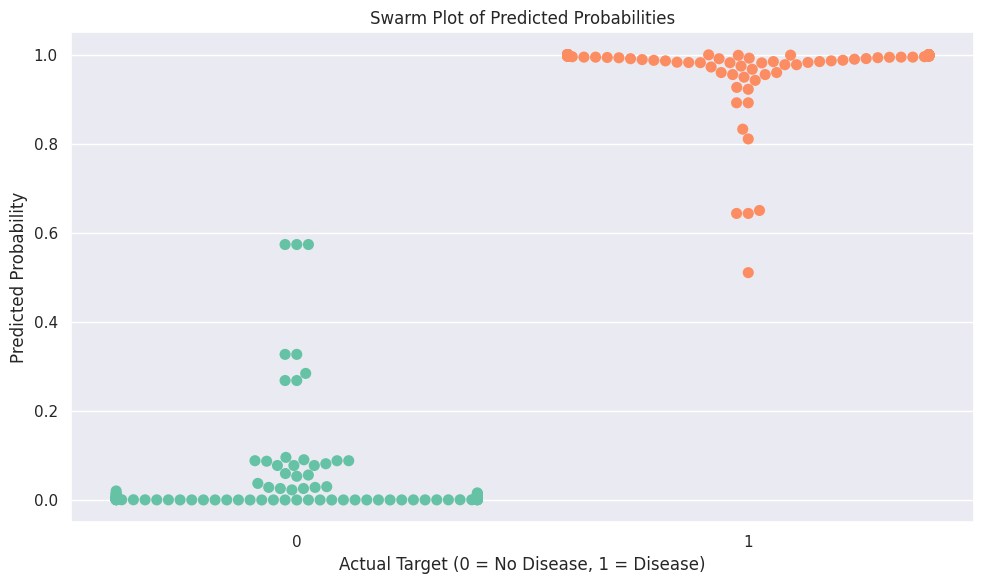

In [60]:
# 7.4 Swarm Plot for Predicted Probabilities
# Create a DataFrame with actual target and predicted probabilities
prob_df = pd.DataFrame({'Actual': y_test, 'Predicted_Prob': y_pred_prob})
plt.figure(figsize=(10,6))
sns.swarmplot(x='Actual', y='Predicted_Prob', data=prob_df, palette="Set2", size=8)
plt.xlabel("Actual Target (0 = No Disease, 1 = Disease)")
plt.ylabel("Predicted Probability")
plt.title("Swarm Plot of Predicted Probabilities")
plt.tight_layout()
plt.show()

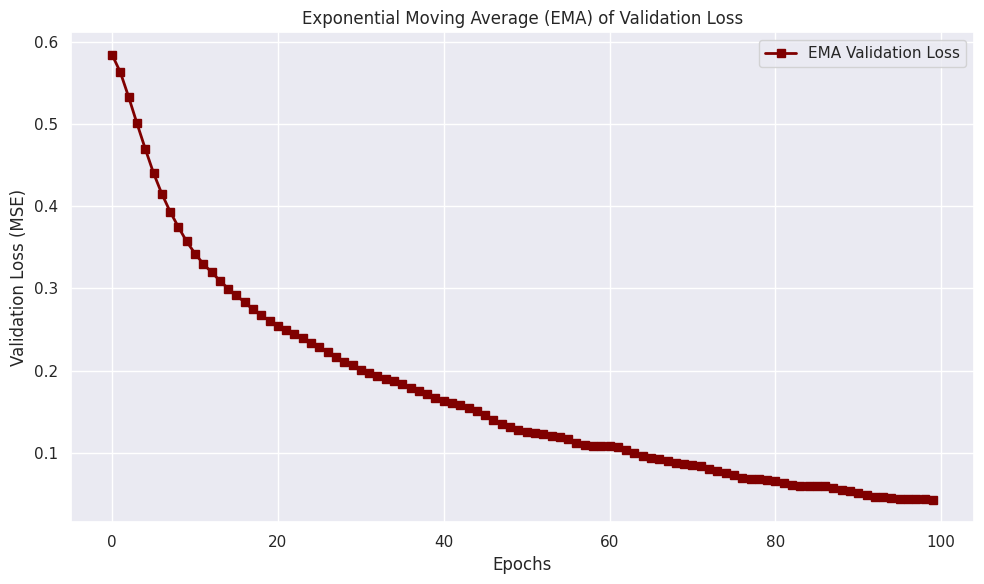

In [61]:
# 7.5 Learning Curve: Smoothed Validation Loss using Exponential Moving Average
loss_df = pd.DataFrame(history.history)
loss_df['EMA_val_loss'] = loss_df['val_loss'].ewm(span=5, adjust=False).mean()
plt.figure(figsize=(10,6))
plt.plot(loss_df['EMA_val_loss'], marker='s', linestyle='-', color='maroon', linewidth=2, label='EMA Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (MSE)")
plt.title("Exponential Moving Average (EMA) of Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()